In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
sys.path.insert(0,"/home/daqtest/Processor/sandpro")
import sandpro
import configparser
import json
%run ../WaveformProcessor.py

### Check which datasets are available

In [2]:
data_folder = "/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output"

In [3]:
meta_data_list = glob.glob(f"{data_folder}/*meta*")
meta_data_list

['/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/meta_config_11_2450_20240425_201731.json',
 '/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/meta_config_2_2550_20240425_154739.json',
 '/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/meta_config_5_2450_20240425_163716.json',
 '/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/meta_config_8_2450_20240425_174015.json',
 '/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/meta_config_15_2450_20240425_214102.json',
 '/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/meta_config_9_2450_20240425_174016.json',
 '/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/meta_config_7_2450_20240425_174015.json',
 '/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/meta_config_16_2450_20240425_215748.json',
 '/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/meta_config_6_2450_20240425_164011.json',
 '/home/daqtest/DAQ/Sandy

### Extract the config name, and fing the config in the tmp folder

In [4]:
meta_data = meta_data_list[5]
meta_data_basename = os.path.basename(meta_data)
parts = meta_data_basename.split('_')
config_name = "_".join(parts[1:4]) + ".ini"
threshold_adc = parts[3]
channel = int(parts[2])
print(config_name)
config_path = os.path.join(data_folder, "tmp",config_name)
config = configparser.ConfigParser()
config.optionxform = str
config.read(config_path)

config_9_2450.ini


### Set the processor config

In [6]:
process_config = {"nchs": 1,
 "nsamps": int(config.get("COMMON", "RECORD_LENGTH")),
 "sample_selection": 120,
 "samples_to_average": 40
}

# dump the config to a json file
with open("process_config.json", "w") as f:
    json.dump(process_config, f)
if len(config.get("BOARD-0", "CHANNEL_LIST")) > 0:
    board_number = 0
else:
    board_number = 1

### Load Data and Process waveform

In [8]:
processor= sandpro.processing.rawdata.RawData(config_file = "process_config.json",
                                               perchannel=False)
data_file_basename = meta_data_basename.replace("meta_", "").replace(".json", f"_board_{board_number}.bin")
data_file_basename

/home/daqtest/Processor/sandpro/sandpro/processing/rawdata.py:11: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  self.rawdata_dtype = np.dtype([('data_per_channel', 'f8',


'config_9_2450_20240425_174016_board_0.bin'

In [9]:
data = processor.get_rawdata_numpy(n_evts=1600,
                                   file=os.path.join(data_folder, data_file_basename),
                                   bit_of_daq=14,
                                   headersize=4,inversion=False)

In [10]:
start_index, end_index = 1500, 1600

wfp = WFProcessor(data_folder, volt_per_adc=2/2**14)
wfp.set_data(data["data_per_channel"][start_index:end_index,0])

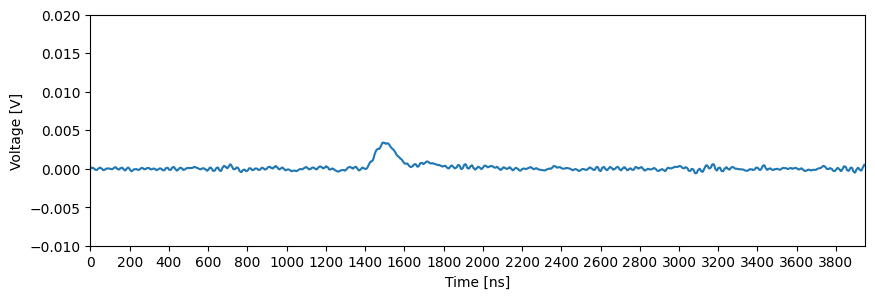

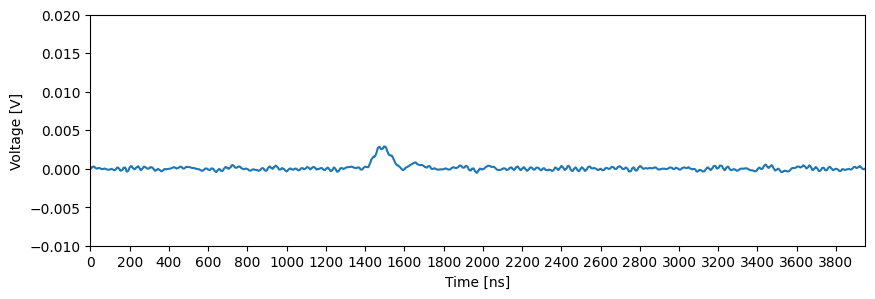

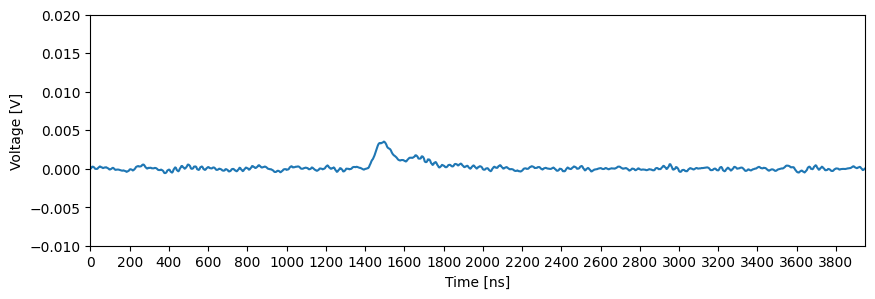

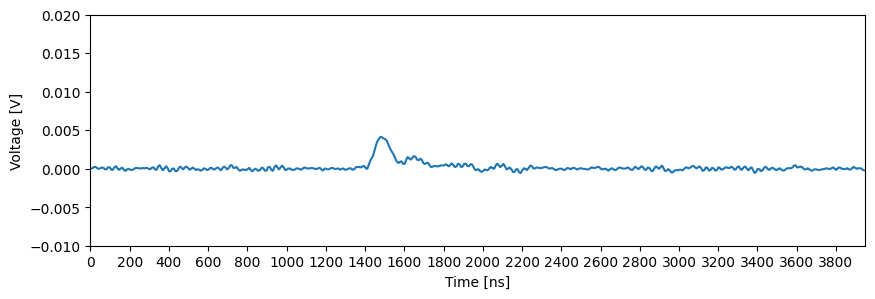

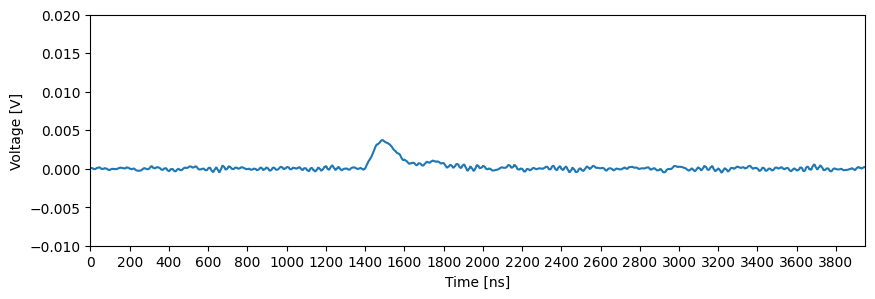

In [11]:
wfp.process_wfs()
wfp.plot_random_wfs(5,filtered=True)

### Calculate optimal threshold

Text(0.5, 1.0, 'channel 9')

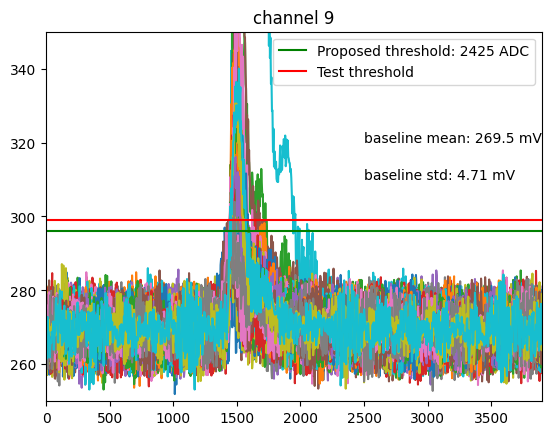

In [12]:
baseline_std = np.mean(wfp.baseline_rms)
baseline_mean = np.mean(wfp.baseline)

threshold_mv = float(threshold_adc) * (2/2**14.) * 1000.
# set the threshold to be 2 * Vpp
optimal_threshold_mv = baseline_mean + 2 * (2 * np.sqrt(2) * baseline_std)
optimal_threshold_adc = int(optimal_threshold_mv / (2/2**14.)/1000 )


time = np.arange(0, process_config["nsamps"], 1) * 4
for i in range(start_index,end_index):
    plt.plot(time, data["data_per_channel"][i][0])
plt.axhline(optimal_threshold_mv, color='g',label=f"Proposed threshold: {optimal_threshold_adc} ADC")
plt.axhline(threshold_mv, color='r',label="Test threshold")
plt.text(2500,320,f"baseline mean: {baseline_mean:.1f} mV")
plt.text(2500,310,f"baseline std: {baseline_std:.2f} mV")

plt.ylim(250,350)
plt.xlim(0,3900)
plt.legend()
plt.title(f"channel {channel}")

### Plot the area distribution

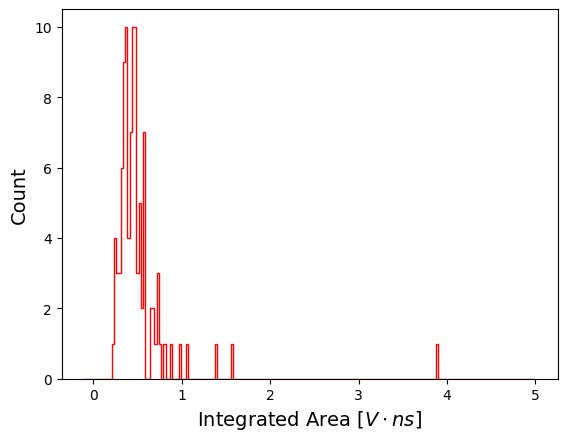

In [13]:
areas = wfp.get_area(sum_window=(0.3,0.4))
plt.hist(areas,bins=200,range=(-0.1,5),histtype='step',color='red',label="Channel 0")
plt.ylabel("Count",fontsize=14)
plt.xlabel("Integrated Area [$V\cdot ns$]",fontsize=14)
#plt.ylim(0,100)
plt.show()

### Loop for all channels

config_0_2520.ini


/home/daqtest/Processor/sandpro/sandpro/processing/rawdata.py:11: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  self.rawdata_dtype = np.dtype([('data_per_channel', 'f8',


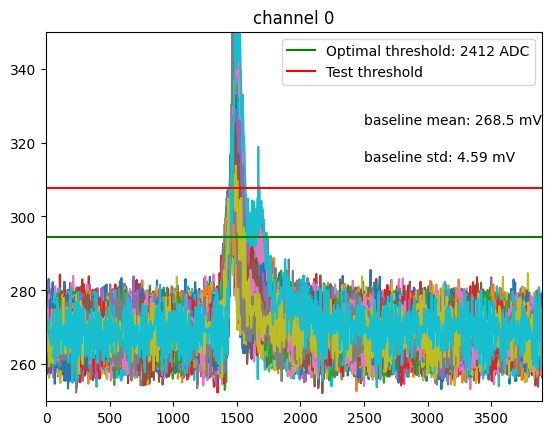

config_1_2520.ini
could not broadcast input array from shape (834,) into shape (1980,)


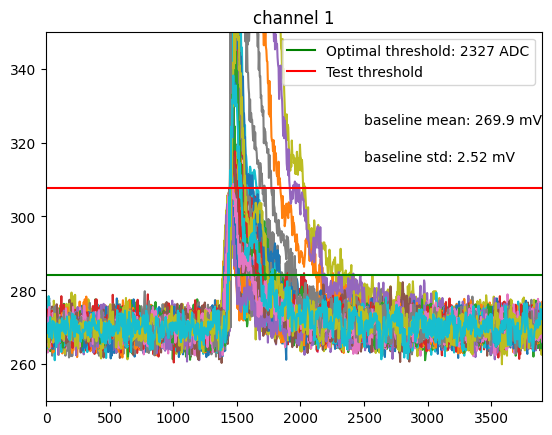

config_2_2550.ini


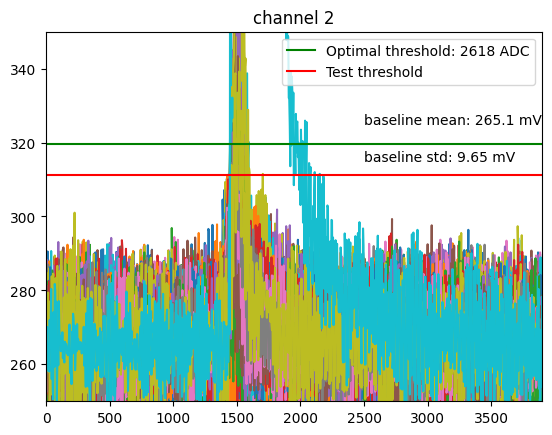

config_3_2450.ini


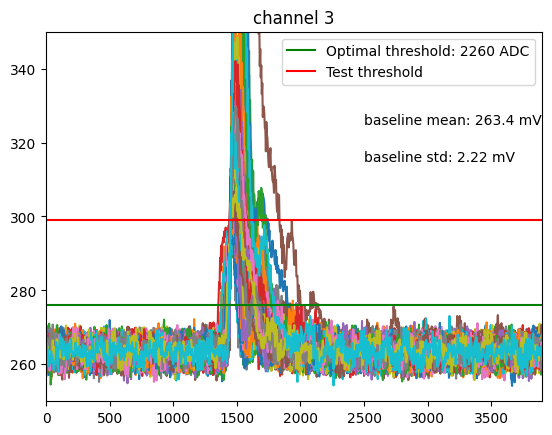

config_4_2450.ini


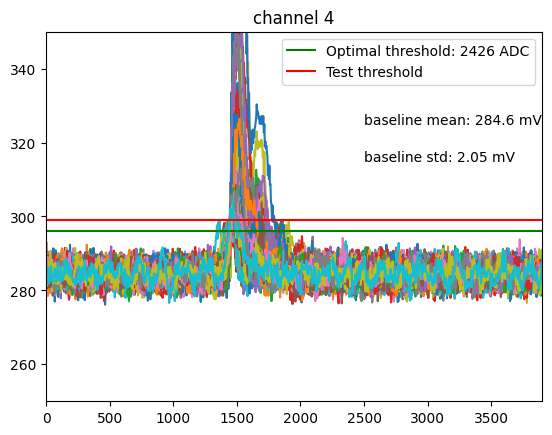

config_5_2450.ini


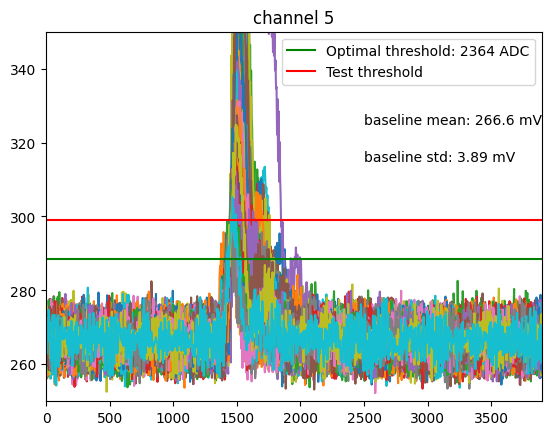

config_6_2450.ini


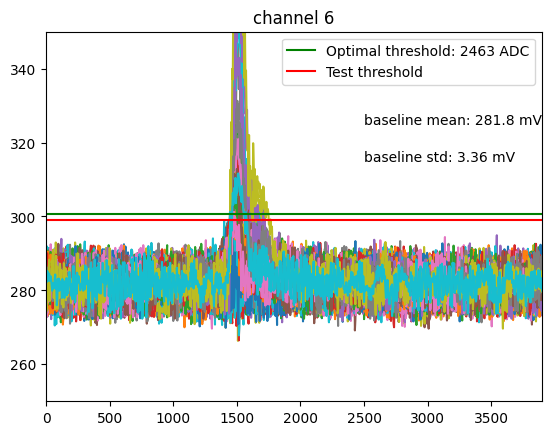

config_7_2450.ini


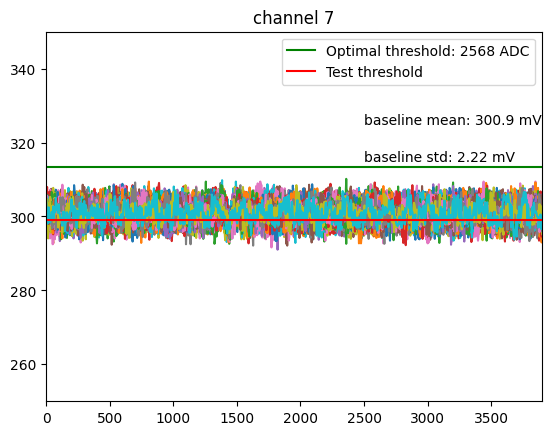

config_8_2450.ini


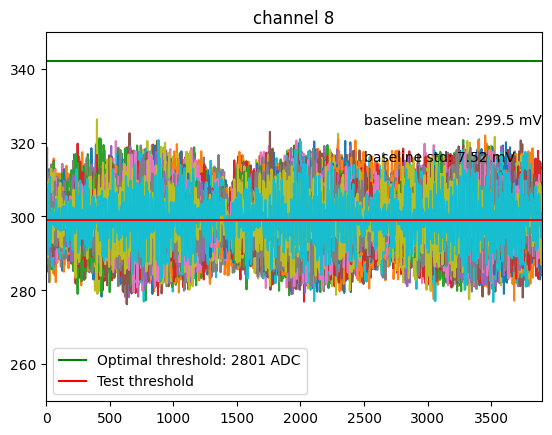

config_9_2450.ini


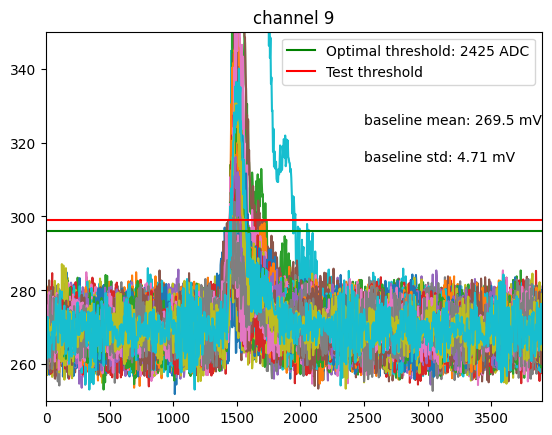

config_10_2450.ini


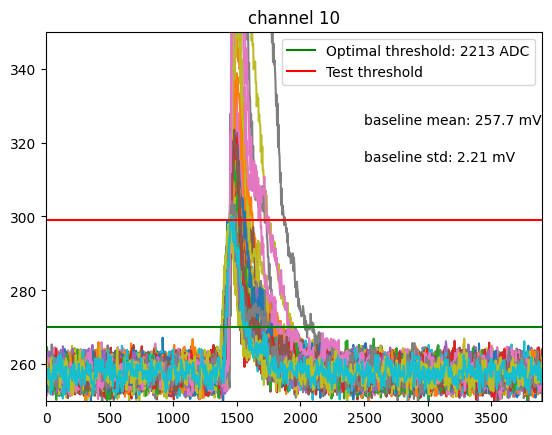

config_11_2450.ini


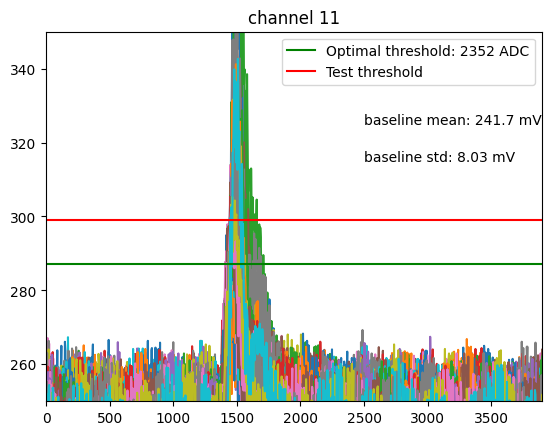

config_12_2450.ini


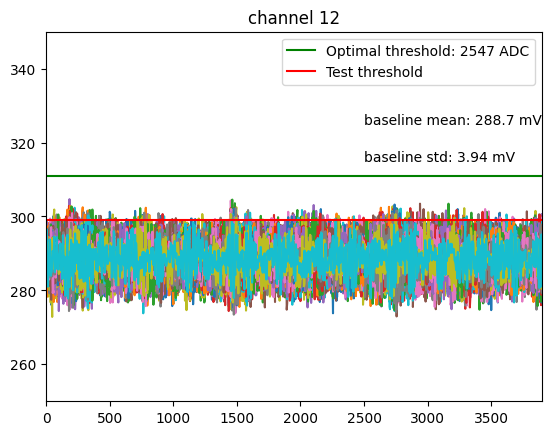

config_13_2450.ini


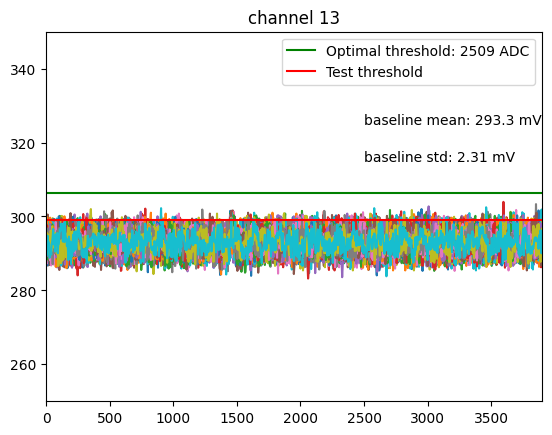

config_14_2450.ini


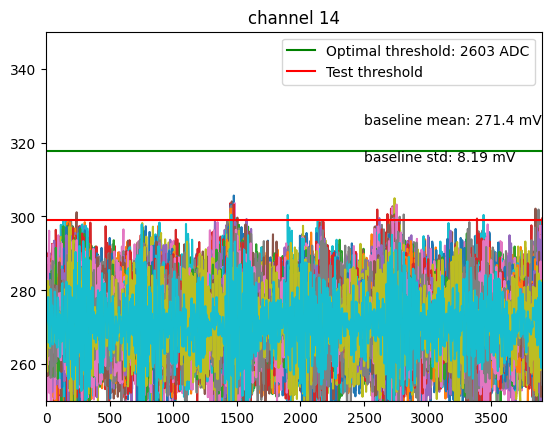

config_15_2450.ini


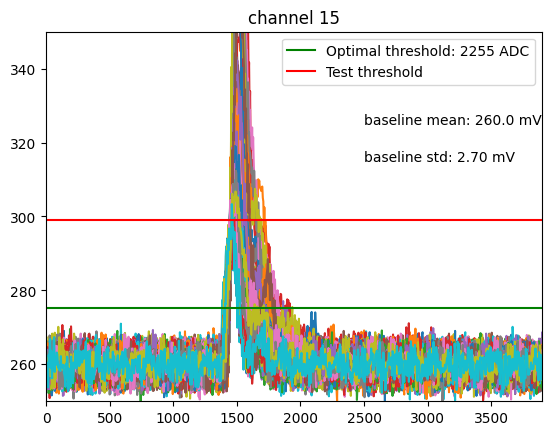

config_16_2450.ini


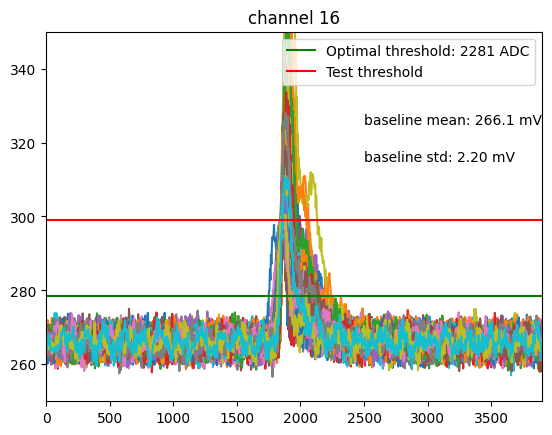

config_17_2450.ini


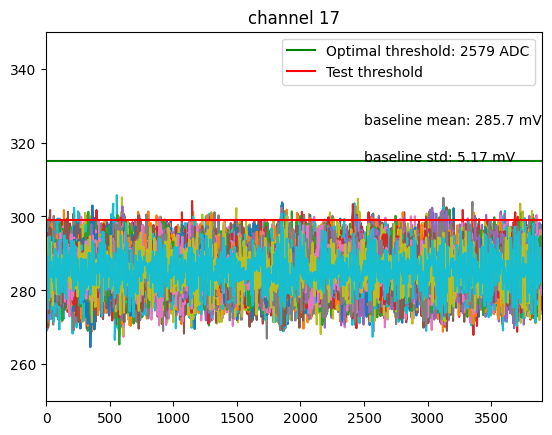

config_18_2450.ini


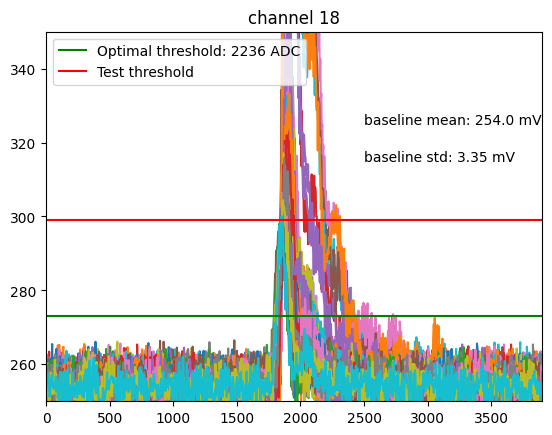

config_19_2450.ini


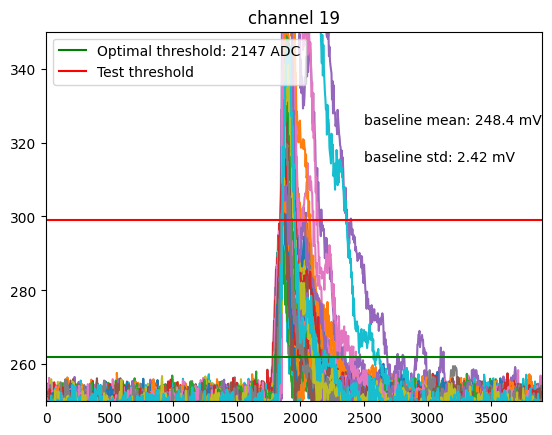

config_20_2450.ini


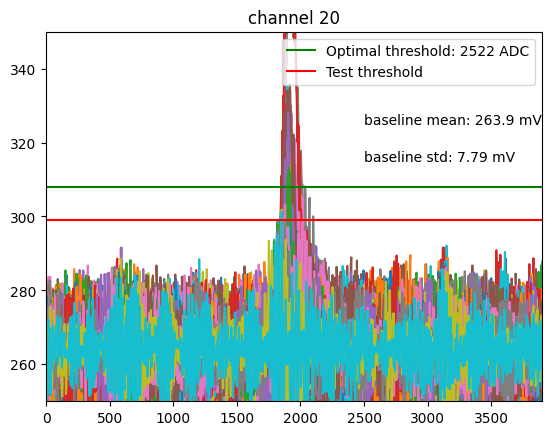

config_21_2450.ini


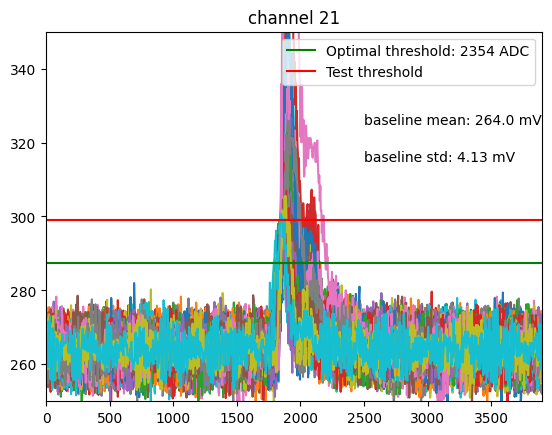

config_22_2450.ini


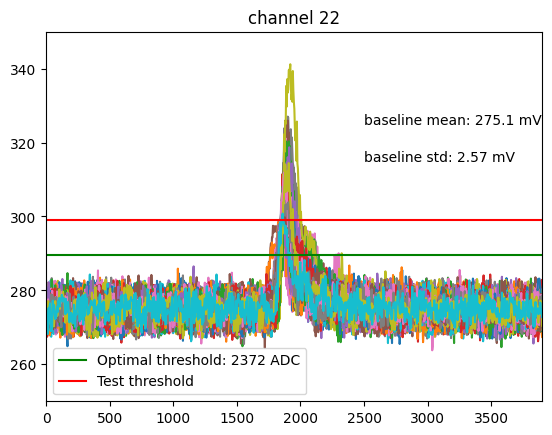

config_23_2450.ini


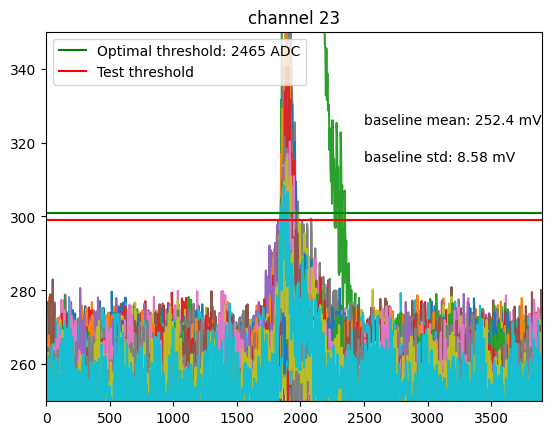

In [26]:
# sort meta_data_list by channel number
sorted_meta_data_list = sorted(meta_data_list, key=lambda x: int(x.split('_')[-4]))

baseline_mean_list = []
baseline_std_list = []
for i in range(len(meta_data_list)):
    meta_data = sorted_meta_data_list[i]
    meta_data_basename = os.path.basename(meta_data)
    parts = meta_data_basename.split('_')
    config_name = "_".join(parts[1:4]) + ".ini"
    threshold_adc = parts[3]
    channel = int(parts[2])
    print(config_name)
    config_path = os.path.join(data_folder, "tmp",config_name)
    config = configparser.ConfigParser()
    config.optionxform = str
    config.read(config_path)

    process_config = {"nchs": 1,
    "nsamps": int(config.get("COMMON", "RECORD_LENGTH")),
    "sample_selection": 120,
    "samples_to_average": 40
    }

    # dump the config to a json file
    with open("process_config.json", "w") as f:
        json.dump(process_config, f)
    if len(config.get("BOARD-0", "CHANNEL_LIST")) > 0:
        board_number = 0
    else:
        board_number = 1

    processor= sandpro.processing.rawdata.RawData(config_file = "process_config.json",
                                               perchannel=False)
    data_file_basename = meta_data_basename.replace("meta_", "").replace(".json", f"_board_{board_number}.bin")
    try:
        data = processor.get_rawdata_numpy(n_evts=1980,
                                    file=os.path.join(data_folder, data_file_basename),
                                    bit_of_daq=14,
                                    headersize=4,inversion=False)
        start_index, end_index = 1500, 1600
    except Exception as e:
        print(e)
        data = processor.get_rawdata_numpy(n_evts=830,
                                    file=os.path.join(data_folder, data_file_basename),
                                    bit_of_daq=14,
                                    headersize=4,inversion=False)
        start_index, end_index = 750, 800
    

    wfp = WFProcessor(data_folder, volt_per_adc=2/2**14)
    wfp.set_data(data["data_per_channel"][start_index:end_index,0])
    wfp.process_wfs()
    baseline_std = np.mean(wfp.baseline_rms)
    baseline_mean = np.mean(wfp.baseline)
    baseline_mean_list.append(baseline_mean)
    baseline_std_list.append(baseline_std)

    threshold_mv = float(threshold_adc) * (2/2**14.) * 1000.
    # set the threshold to be 2 * Vpp
    optimal_threshold_mv = baseline_mean + 2 * (2 * np.sqrt(2) * baseline_std)
    optimal_threshold_adc = int(optimal_threshold_mv / (2/2**14.)/1000 )


    time = np.arange(0, process_config["nsamps"], 1) * 4
    for i in range(start_index,end_index):
        plt.plot(time, data["data_per_channel"][i][0])
    plt.axhline(optimal_threshold_mv, color='g',label=f"Optimal threshold: {optimal_threshold_adc} ADC")
    plt.axhline(threshold_mv, color='r',label="Test threshold")
    plt.text(2500,325,f"baseline mean: {baseline_mean:.1f} mV")
    plt.text(2500,315,f"baseline std: {baseline_std:.2f} mV")

    plt.ylim(250,350)
    plt.xlim(0,3900)
    plt.legend()
    plt.title(f"channel {channel}")
    plt.savefig(f"test_threshold_channel_{channel}.png")
    plt.show()

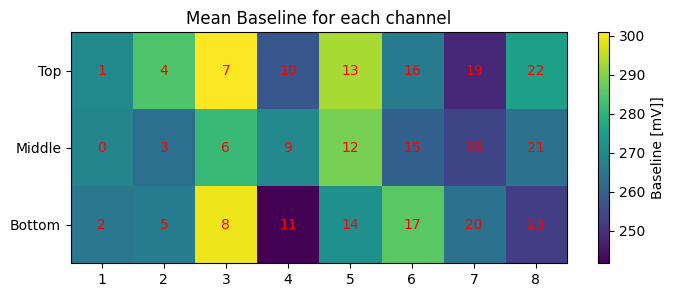

In [48]:
# Create a 2D array with the specified index sequence
array_2d = np.zeros((3, 8))
for col in range(8):
    array_2d[:, col] = [baseline_mean_list[col*3+1], baseline_mean_list[col*3], baseline_mean_list[col*3+2]]
# Plot the 2D array using colormap
plt.figure(figsize=(8, 3))
plt.imshow(array_2d, cmap='viridis', aspect='auto')
plt.colorbar(label='Baseline [mV]]')

# Add index labels to each cell
for i in range(3):
    for j in range(8):
        index = j * 3 + (1 if i == 0 else 0 if i == 1 else 2)
        plt.text(j, i, str(index), ha='center', va='center', color='r')



plt.xticks(range(8), range(1, 9))
plt.yticks(range(3), ['Top', 'Middle', 'Bottom'])
plt.title('Mean Baseline for each channel')
plt.savefig("baseline_mean.png")
plt.show()

In [44]:
baseline_mean_list

[268.54905395507814,
 269.8987731933594,
 265.12244567871096,
 263.40155334472655,
 284.58160705566405,
 266.59633178710936,
 281.7651062011719,
 300.9263885498047,
 299.4765563964844,
 269.48753662109374,
 257.7431945800781,
 241.70779113769532,
 288.72539672851565,
 293.2530487060547,
 271.4480895996094,
 260.0088775634766,
 266.06104431152346,
 285.69188537597654,
 254.0421569824219,
 248.41827087402345,
 263.8928741455078,
 264.0042999267578,
 275.0638732910156,
 252.41446533203126]

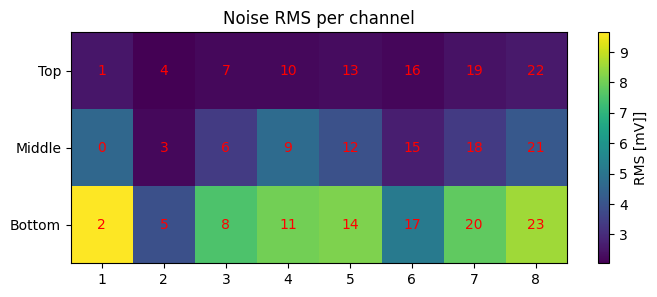

In [49]:
# Create a 2D array with the specified index sequence
array_2d = np.zeros((3, 8))
for col in range(8):
    array_2d[:, col] = [baseline_std_list[col*3+1], baseline_std_list[col*3], baseline_std_list[col*3+2]]
# Plot the 2D array using colormap
plt.figure(figsize=(8, 3))
plt.imshow(array_2d, cmap='viridis', aspect='auto')
plt.colorbar(label='RMS [mV]]')

# Add index labels to each cell
for i in range(3):
    for j in range(8):
        index = j * 3 + (1 if i == 0 else 0 if i == 1 else 2)
        plt.text(j, i, str(index), ha='center', va='center', color='r')



plt.xticks(range(8), range(1, 9))
plt.yticks(range(3), ['Top', 'Middle', 'Bottom'])
plt.title('Noise RMS per channel')
plt.savefig("baseline_std.png")
plt.show()